# Interactive plots

## Line plots

In [2]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import requests_cache
from retry_requests import retry
import openmeteo_requests
from openmeteo_sdk.Variable import Variable
from earthkit.plots.interactive import Chart

Fetching data from Open-Meteo for observations and forecast.

In [3]:
today = datetime.now()
yesterday = today - timedelta(days=1)
two_days_ago = today - timedelta(days=2)

today_str = today.strftime('%Y-%m-%d')
yesterday_str = yesterday.strftime('%Y-%m-%d')
two_days_ago_str = two_days_ago.strftime('%Y-%m-%d')

In [4]:
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Forecast data
ensemble_url = "https://ensemble-api.open-meteo.com/v1/ensemble"
ensemble_params = {
    "latitude": 47.4583,
    "longitude": 8.5480,
    "start_date": yesterday_str,
    "end_date": today_str,
    "hourly": "temperature_2m",
    "models": "meteoswiss_icon_ch1",
}
ensemble_response = openmeteo.weather_api(ensemble_url, params=ensemble_params)[0]
print("Fetched ensemble data for Zurich.")

Fetched ensemble data for Zurich.


In [5]:
# Past data
archive_url = "https://archive-api.open-meteo.com/v1/archive"
archive_params = {
    "latitude": 47.4583,
    "longitude": 8.5480,
    "start_date": two_days_ago_str,
    "end_date": yesterday_str,
    "hourly": "temperature_2m",
}
archive_response = openmeteo.weather_api(archive_url, params=archive_params)[0]
print("Fetched archive data for Zurich.")

Fetched archive data for Zurich.


Convert forecast timestamps to Pandas DateTimeIndex (for png rendering).
Store each ensemble member as a separate column.

In [6]:
# Process forecast data
forecast_hourly = ensemble_response.Hourly()

forecast_data = {
    "date": pd.date_range(
        start=pd.to_datetime(forecast_hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(forecast_hourly.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=forecast_hourly.Interval()),
        inclusive="left"
    )
}

for i in range(forecast_hourly.VariablesLength()):
    variable = forecast_hourly.Variables(i)
    member = variable.EnsembleMember()
    forecast_data[f"temperature_2m_member_{member}"] = variable.ValuesAsNumpy()

forecast_df = pd.DataFrame(forecast_data)

Ensure time alignment with the forecast data.

In [7]:
# Process archive data
archive_hourly = archive_response.Hourly()
archive_temp_data = archive_hourly.Variables(0).ValuesAsNumpy()

archive_time_index = pd.date_range(
    start=pd.to_datetime(archive_hourly.Time(), unit="s", utc=True),
    periods=len(archive_temp_data),
    freq=pd.Timedelta(seconds=archive_hourly.Interval())
)

archive_df = pd.DataFrame(data={
    "date": archive_time_index,
    "temperature_2m_observed": archive_temp_data
})

Merge datasets for a unified time series to ensure continuity.

In [8]:
# Merge the DataFrames
combined_df = (pd.merge(archive_df, forecast_df, on="date", how="outer")
                 .sort_values("date").reset_index(drop=True))

combined_df["date"] = (pd.to_datetime(combined_df["date"], utc=True)
                         .dt.tz_convert("Europe/Zurich")
                         .dt.tz_localize(None))

pd.concat([combined_df.head(2), combined_df.tail(2)])

,date,temperature_2m_observed,temperature_2m_member_0,temperature_2m_member_1,temperature_2m_member_2,temperature_2m_member_3,temperature_2m_member_4,temperature_2m_member_5,temperature_2m_member_6,temperature_2m_member_7,temperature_2m_member_8,temperature_2m_member_9,temperature_2m_member_10
0,2025-08-11 02:00:00,18.539999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-08-11 03:00:00,17.889999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,2025-08-14 00:00:00,NaN,20.019501,21.519501,20.519501,19.219501,23.369501,21.519501,19.719501,22.769501,18.469501,20.869501,18.469501
71,2025-08-14 01:00:00,NaN,18.819500,19.969501,19.069500,17.719501,21.019501,18.369501,18.219501,21.619501,18.819500,21.019501,17.819500


In [9]:
# Prepare data for plotting
past_df = combined_df[["date", "temperature_2m_observed"]].dropna()
member_columns = [c for c in combined_df.columns if "member" in c]
forecast_df_ok = combined_df[["date"] + member_columns].dropna(subset=member_columns, how="all")

x_obs = past_df["date"].dt.to_pydatetime().tolist()
y_obs = past_df["temperature_2m_observed"].astype(float).tolist()

/tmp/ipykernel_3039/2285448420.py:6: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  x_obs = past_df["date"].dt.to_pydatetime().tolist()


Calculate ensemble statistics.

In [10]:
x_fcst = forecast_df_ok["date"].dt.to_pydatetime().tolist()
Y_fcst = forecast_df_ok[member_columns].to_numpy(dtype=float)
p5_vals  = np.nanpercentile(Y_fcst, 5, axis=1) if Y_fcst.size else np.array([])
p95_vals = np.nanpercentile(Y_fcst, 95, axis=1) if Y_fcst.size else np.array([])
med_vals = np.nanmedian(Y_fcst, axis=1) if Y_fcst.size else np.array([])

/tmp/ipykernel_3039/3085387346.py:1: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  x_fcst = forecast_df_ok["date"].dt.to_pydatetime().tolist()


Plot with Chart.
* Observed data
* Shaded data for uncertainty
* Forecast median
* Forecast members
* Dashed line separating past observations from forecast

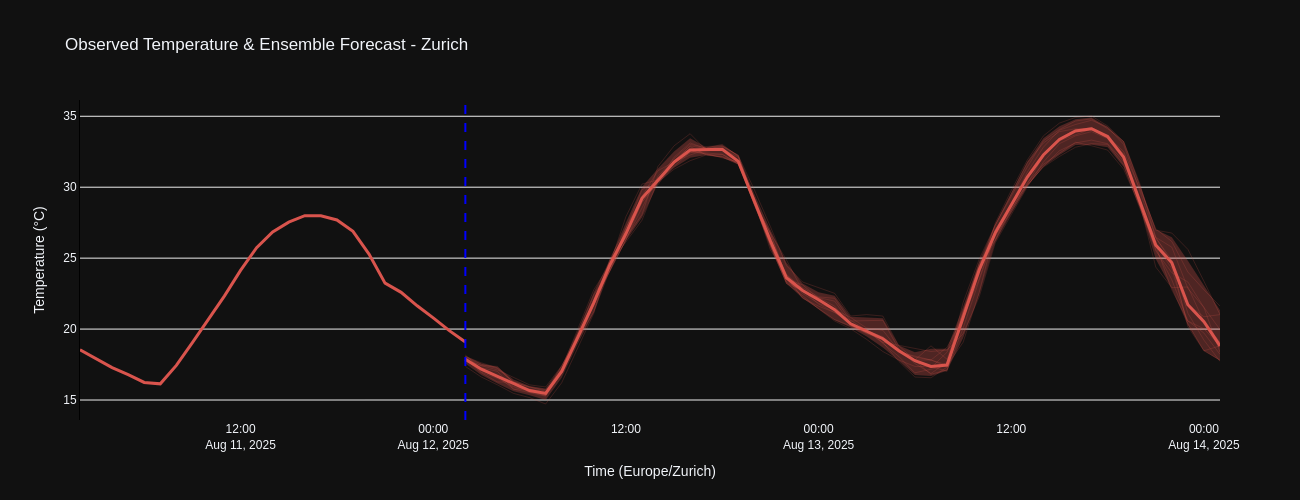

In [11]:
chart= Chart()

chart.title("Observed Temperature & Ensemble Forecast - Zurich")

# Observed
if x_obs:
    chart.line(x=x_obs, y=y_obs, line_color="rgb(217, 84, 77)", line_width=3, name="Observed")

# Spread band
if len(x_fcst) and p5_vals.size and p95_vals.size:
    chart.line(x=x_fcst, y=p95_vals, line_width=0, showlegend=False)
    chart.line(x=x_fcst, y=p5_vals, line_width=0, fill="tonexty",
               fillcolor="rgba(217, 84, 77, 0.3)", showlegend=False, name="5-95% Spread")

# Median
if len(x_fcst) and med_vals.size:
    chart.line(x=x_fcst, y=med_vals, line_color="rgb(217, 84, 77)", line_width=3, name="Forecast Median")

# Individual members
if Y_fcst.size:
    for i in range(Y_fcst.shape[1]):
        chart.line(x=x_fcst, y=Y_fcst[:, i],
                   line_color="rgb(217, 84, 77)", opacity=0.2, line_width=1, showlegend=False)

# Boundary line
if x_obs:
    chart.fig.add_vline(x=max(x_obs), line_dash="dash", line_color="blue", line_width=2)

# Axes/layout
chart.fig.update_xaxes(type="date", title_text="Time (Europe/Zurich)")
chart.fig.update_yaxes(title_text="Temperature (°C)")
chart.fig.update_layout(template="plotly_dark")

# Render
chart.show(renderer="png",width=1300, height=500)

## Bar charts

In [12]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import xarray as xr

import requests_cache
import openmeteo_requests
from openmeteo_sdk.Variable import Variable
from retry_requests import retry

import plotly.graph_objects as go
from earthkit.plots.interactive import Chart
from earthkit.plots.interactive import bar as bar_module


In [30]:
today = datetime.now() + timedelta(days=-3)
tomorrow = today + timedelta(days=5)

today_str = today.strftime("%Y-%m-%d")
tomorrow_str = tomorrow.strftime("%Y-%m-%d")

cache_session = requests_cache.CachedSession(".cache", expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

ensemble_url = "https://ensemble-api.open-meteo.com/v1/ensemble"
params = {
    "latitude": 60.3913, # Bergen, Norway - rainiest city in Europe
    "longitude": 5.3221,
    "start_date": today_str,
    "end_date": tomorrow_str,
    "hourly": "precipitation",
    "models": "ecmwf_ifs025",
}
ensemble_response = openmeteo.weather_api(ensemble_url, params=params)[0]


In [31]:
forecast_hourly = ensemble_response.Hourly()

forecast_data = {"date": pd.date_range(
        start=pd.to_datetime(forecast_hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(forecast_hourly.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=forecast_hourly.Interval()),
        inclusive="left"
    ).tz_convert("Europe/Zurich").tz_localize(None)}

for i in range(forecast_hourly.VariablesLength()):
    v = forecast_hourly.Variables(i)
    member = v.EnsembleMember()
    forecast_data[f"precip_member_{member}"] = v.ValuesAsNumpy()

forecast_df = pd.DataFrame(forecast_data)

member_cols = [c for c in forecast_df.columns if "member" in c]

forecast_df_ok = forecast_df[["date"] + member_cols].dropna(subset=member_cols, how="all")


In [32]:
# Quantile band
q_low, q_high = 0.33, 0.66

x = forecast_df_ok["date"].dt.to_pydatetime().tolist()
Y = forecast_df_ok[member_cols].to_numpy(dtype=float)

med = np.nanmedian(Y, axis=1)
lo  = np.nanpercentile(Y, q_low*100,  axis=1)
hi  = np.nanpercentile(Y, q_high*100, axis=1)

band_height = hi - lo

/tmp/ipykernel_3039/3709086221.py:4: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



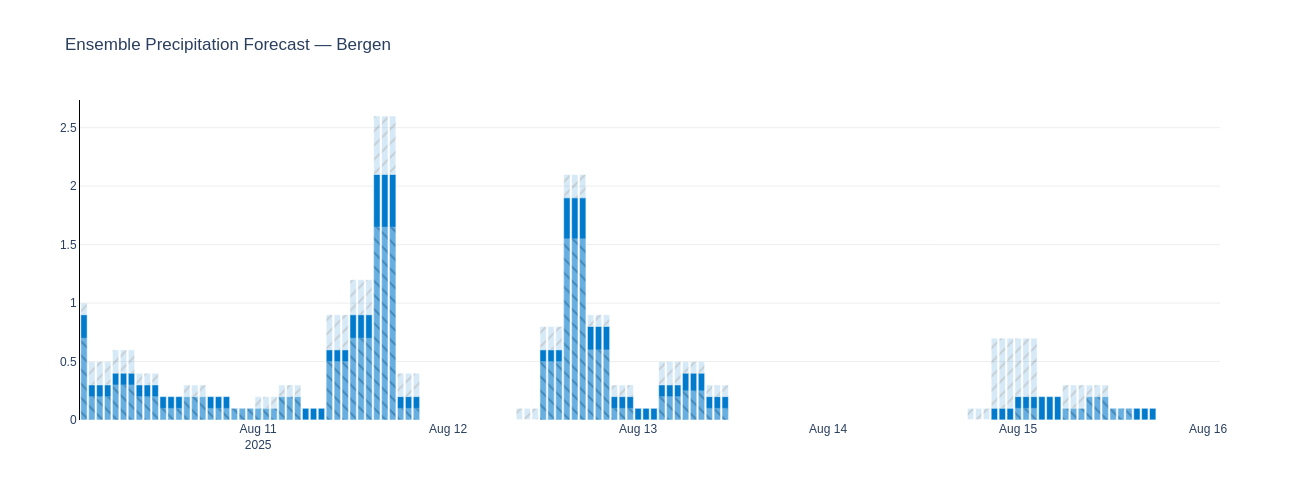

In [ ]:
chart = Chart()
chart.title("Ensemble Precipitation Forecast — Bergen")

# Upper quantile
for tr in bar_module.bar(
    x=x,
    y=hi,
    name=f"Q{int(q_high*100)}",
    marker=dict(color="rgba(0, 122, 204, 0.4)",
                pattern=dict(shape="/")),
    opacity=0.4,
    showlegend=True,
):
    chart.add_trace(tr)

# Median bar
for tr in bar_module.bar(
    x=x,
    y=med,
    name="Median (bar)",
    marker=dict(color="rgb(0, 122, 204)"),
    showlegend=True,
):
    chart.add_trace(tr)

# Lower quantile
for tr in bar_module.bar(
    x=x,
    y=lo,
    name=f"Q{int(q_low*100)}",
    marker=dict(color="white",
                pattern=dict(shape="\\")),
    opacity=0.4,
    showlegend=True,
):
    chart.add_trace(tr)

# Layout
chart.fig.update_layout(
    barmode="overlay",
    template="plotly_white",
    legend=dict(itemsizing="constant"),
)
chart.show(renderer="png", width=1300, height=500)